# Multidimensional search

## What information is available? 

Access to calling the function $f(x)$ that is to be minimised is understood (but in fact, the situation changes slightly if we can only access it in the presence of noise!). 

- If there is no access to the gradient, we need to perform a __direct search__, some form of generalisation of the interval search for multiple variables. A longer course would include for example the __Nelder-Mead__ method.

 - This is often the case when the objective function is the result of a complex simulation (think "lift on an aircraft wing" or "melting point of a material")
 - Sometimes one can try to create a __surrogate model__, which approximates the objective function, but provides analytical gradients. (Same idea _again_ of solving a slightly different problem than the original)
 

(Why would it _not_ make sense to obtain a gradient by finite differences?)
 

- Access to the gradient enables __gradient search__, which is much more efficient than direct search

- Access to the Hessian can improve convergence signicantly, but using it comes with its own problems (do be discussed)

- Even a rough approximation of the Hessian can be extremely beneficial. 

## Steepest Descent

The most naive algorithm:

1. New direction is -ve of the local gradient: $d_k = -g(x_k)$
1. Determine the step size $\alpha_k$ by _line search_ for the minimum of $f(x)$ _along_ $d_k$ 
1. Update $x_{k+1} = x_k + \alpha_k d_k$
1. If not converged, back to 1. 

Notice __nested structure__: main loop changes _directions_, inner loop in step 2. is optimisation in 1D. How accurate should the line search be?

- Too few steps will mean that the algorithm might not converge
- Too many steps are a waste of resources.

Successive directions are approximately orthogonal: $$d^T_k d_{k+1} \approx 0$$

In [3]:
from pylab import *
import numpy as np
# function we will optimize
def Rosen(x,a=10):
    return (1-x[0])**2 + a*(x[1]-x[0]**2)**2
def dRosen(x,a=10):
    return np.array([-2.0*(1.0-x[0]) - 2.0*a*(x[1]-x[0]**2)*2.0*x[0],2.0*a*(x[1]-x[0]**2)])


In [6]:
def linesearch_golden_section(f, x, d, alpha_init=None, xtol=1e-3):
    
    def fa(a):
        return f(x+a*d)
    
    # initial point
    alpha0 = 0
    f0 = fa(alpha0)
    
    # now find a bracket for the minimum
    if alpha_init == None:
        alpha1 = 1
    else:
        alpha1 = alpha_init
        
    # check to see if the point at alpha1 goes down, if not find one that does
    while fa(alpha1) > f0:
        alpha1 /= 2.0
        #print (alpha0, f0, alpha1, fa(alpha1))
    
    f1 = fa(alpha1)
    
    # set up golden section ratio
    r = (np.sqrt(5)-1)/2.0
    # now find the outer bracket alpha2 where the function goes up again
    alpha2 = alpha1/r
    while fa(alpha2) < f1:
        alpha1 = alpha2
        alpha2 = alpha1/r
    f2 = fa(alpha2)
    
    # now we have three points in Golden Section ratio, (alpha0, alpha1, alpha2) such that the function goes down then up,
    # so it must have a minimum in between
    
    # now loop until convergence
    while abs(alpha0-alpha2) > xtol:
        # get 4th point
        alpha3 = alpha0*r+alpha2*(1-r); f3=fa(alpha3) # 0,3,1,2
        
        # depending on where the function value falls, update the brackets
        if f3 < f1:
            alpha2=alpha1; f2=f1
            alpha1=alpha3; f1=f3
        else:
            alpha0=alpha2; f0=f2
            alpha2=alpha3; f2=f3
    return 0.5*(alpha0+alpha2)
        
    
def steepest_descent(f, df, x0, ftol, xtol=1e-3):
    traj = []
    
    # get initial direction
    x = x0[:]
    d = -1.0*df(x)
    alpha_init = 1e-6
    i = 0
    #print i, f(x), np.linalg.norm(d), x[:], d[:]
    traj.append((x[0],x[1]))

    # loop until convergence
    while np.linalg.norm(d) > ftol:
        i += 1
        # do line search in current direction 
        alpha = linesearch_golden_section(f, x, d, alpha_init, xtol)
        # update estimate
        x += alpha*d
        # get new direction        
        d = -1.0*df(x)
        
        #print i, f(x), np.linalg.norm(d), x[:], d[:]
        traj.append((x[0],x[1]))

    return x[:],traj

        

In [7]:
xmin, traj = steepest_descent(Rosen,dRosen, np.array([-1.3,1.3]), 1e-1, 1e-8)

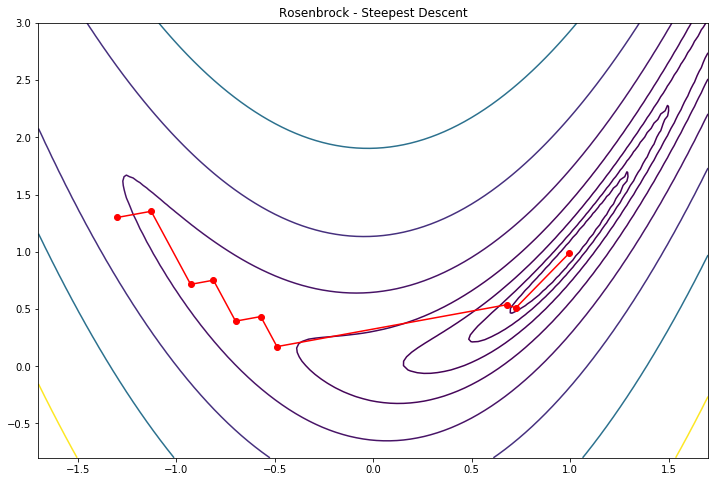

In [8]:
x,y = np.meshgrid(np.linspace(-1.7,1.7,100), np.linspace(-0.8,3,100))
R = [[Rosen(np.array([x[j,i],y[j,i]])) for i in range(size(x,0)) ] for j in range(size(x,1))]

fig = figure(figsize=(12,8))
contour(x, y, R, np.logspace(-1,2, 8), color="k")
title("Rosenbrock - Steepest Descent")
plot([traj[i][0] for i in range(len(traj))], [traj[i][1] for i in range(len(traj))], "r-o")
show()

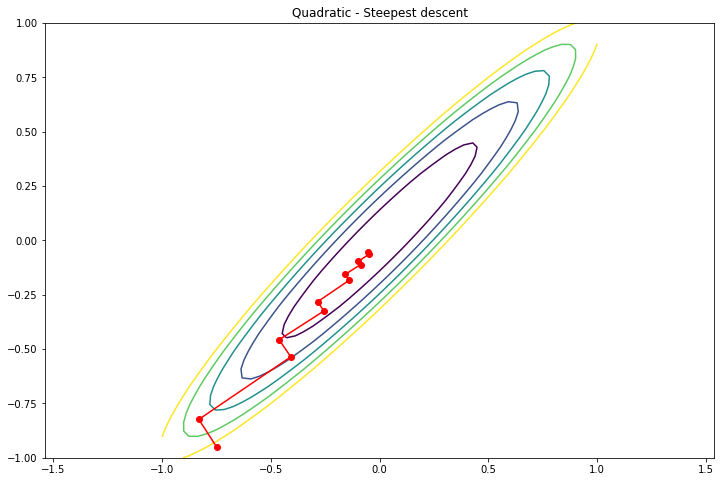

In [45]:
def Q(x):
    return x[0]**2+x[1]**2 - 1.9*x[0]*x[1]
def dQ(x):
    return np.array([2*x[0]-1.9*x[1], 2*x[1]-1.9*x[0]])

x, y = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))
Qxy = [[Q(np.array([x[j,i],y[j,i]])) for i in range(size(x,0)) ] for j in range(size(x,1))]
figure(figsize=(12,8))
contour(x, y, Qxy, linspace(0, 0.1, 6), color="k")
title("Quadratic - Steepest descent")
axis('equal')

xmin, traj = steepest_descent(Q, dQ, np.array([-0.75, -0.95]), 1e-2, 1e-2)
plot([traj[i][0] for i in range(len(traj))], [traj[i][1] for i in range(len(traj))], "r-o")

show()

## Steepest descent convergence

This algorithm converges __linearly__ ($p = 1$), so 

$$ \left\| x_{k+1}-x^*\right\| = \beta \left\| x_k - x^*\right\| $$

The the bigger problem is that $\beta$ is can be close to 1: 

$$ \beta \le \left[\frac{\lambda_\text{max}-\lambda_\text{min}}{\lambda_\text{max}+\lambda_\text{min}}\right]^2 $$

where $\lambda_\text{max}$ and $\lambda_\text{min}$ are the largest and smallest eigenvalues of $H(x^*)$. 

- In typical engineering problems, this ratio approaches 1 as the number of variables increases.
- Quadratic problems with ill-conditioned matrices lead to poor convergence of steepest descent. 

## How can we help this?

Let us suppose for a moment that we can access the Hessian, $H(x)$. In this case, we can apply Newton's method iteartively in multiple dimension. It amounts to approximating the function $f(x)$ by a quadratic using the function value, gradient and Hessian at the current location. 

Taylor expansion: 

$$ f(x_{k+1}) = f(x_k) + \nabla f(x_k)^T (x_{k+1} - x_k) + \frac12 (x_{k+1}-x_k)^T H(x_k) (x_{k+1}-x_k) +\ldots $$

Let 

$$ q(x) = f(x_k) + \nabla f(x_k)^T (x - x_k) + \frac12 (x-x_k)^T H(x_k) (x-x_k) $$

The minimum of $q(x)$ is where $\nabla q(x) = 0$, so 

$$
\begin{array}
\\
\nabla q(x) &= \nabla f(x_k) + H(x_k) (x-x_k) = 0\\
x &= x_k - [H(x_k)]^{-1} \nabla f(x_k)\\
\end{array}
$$

So we now use the minimum of $q(x)$ as our next guess at the minimum of $f(x)$.

$$
x_{k+1} = x_k + \alpha_k d_k
$$

With the direction given by

$$
d_k = - [H(x_k)]^{-1} \nabla f(x_k)
$$

and a step size of $\alpha_k = 1$.

In [14]:
def ddQ(x):
    return np.matrix([[2, -1.9], [-1.9, 2]])

def newton(f, df, ddf, x0, ftol, xtol=1e-3):
    traj = []
    
    # get initial direction
    x = np.array(x0[:])
    d = -1.0*asarray(np.matmul(np.linalg.inv(ddf(x)),df(x)))[0]
    
    i = 0
    #print i, f(x), np.linalg.norm(d), x[:], d[:]
    traj.append((x[0],x[1]))

    # loop until convergence
    while np.linalg.norm(d) > ftol:
        i += 1
        # update estimate
        x += d
        # get new direction        
        d = -1.0*asarray(np.matmul(np.linalg.inv(ddf(x)),df(x)))[0]
        
        #print i, f(x), np.linalg.norm(d), x[:], d[:]
        traj.append((x[0],x[1]))

    return x[:],traj



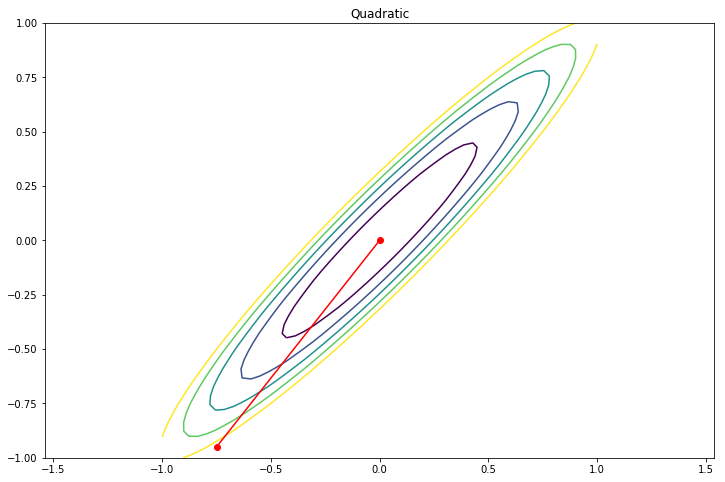

In [15]:
x, y = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))
Qxy = [[Q(np.array([x[j,i],y[j,i]])) for i in range(size(x,0)) ] for j in range(size(x,1))]
figure(figsize=(12,8))
contour(x, y, Qxy, linspace(0, 0.1, 6), color="k")
title("Quadratic")
axis('equal')
xmin, traj = newton(Q, dQ, ddQ, np.array([-0.75, -0.95]), 1e-2, 1e-2)
plot([traj[i][0] for i in range(len(traj))], [traj[i][1] for i in range(len(traj))], "r-o")

show()

### Why did that work so well? 

## Try it on something harder

In [16]:
def ddRosen(x,a=10):
    return np.matrix([[2.0 - 4.0*a*(x[1]-x[0]**2) - 4.0*a*(-2.0*x[0])*x[0], -4.0*a*x[0]],
                      [-4.0*a*x[0]                                        ,   2.0*a ]])

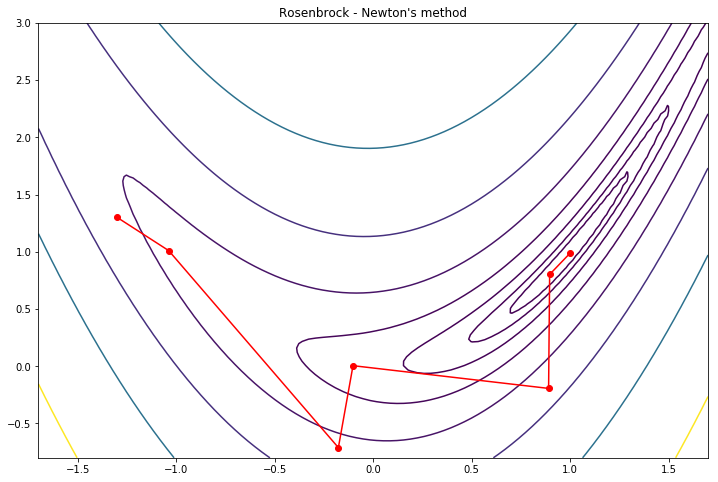

In [43]:
x,y = np.meshgrid(np.linspace(-1.7,1.7,100), np.linspace(-0.8,3,100))
R = [[Rosen(np.array([x[j,i],y[j,i]])) for i in range(size(x,0)) ] for j in range(size(x,1))]

fig = figure(figsize=(12,8))
contour(x, y, R, np.logspace(-1,2, 8), color="k")
title("Rosenbrock - Newton's method")

xmin, traj = newton(Rosen, dRosen, ddRosen, np.array([-1.3, 1.3]), 1e-1, 1e-8)
plot([traj[i][0] for i in range(len(traj))], [traj[i][1] for i in range(len(traj))], "r-o")

show()

## Newton's method: convergence

- It is a __quadratically convergence__ method

$$ \left\| x_{k+1} - x^*\right\| \leq \beta \left\| x_k - x^*\right\|^2 $$

- Once you are quite close to the answer (in the _asymptotic limit_)
- $H(x)$ needs to be positive definite, otherwise can converge to a maximum, a saddle point, etc.
- It can also take you further from the minimum!

## Newton-Raphson method

Pick Newton's direction, but don't assume the Hessian is so good that the step size can be 1, instead do line search. 

In [45]:
def newton_raphson(f, df, ddf, x0, ftol, xtol=1e-3):
    traj = []
    
    # get initial direction
    x = np.array(x0[:])
    d = -1.0*asarray(np.matmul(np.linalg.inv(ddf(x)),df(x)))[0]
    
    i = 0
    #print i, f(x), np.linalg.norm(d), x[:], d[:]
    traj.append((x[0],x[1]))

    alpha_init = 1e-6

    # loop until convergence
    while np.linalg.norm(d) > ftol:
        i += 1
        # do line search in current direction 
        alpha = linesearch_golden_section(f, x, d, alpha_init, xtol)
        #print alpha
        # update estimate
        x += alpha*d
        # get new direction        
        d = -1.0*asarray(np.matmul(np.linalg.inv(ddf(x)),df(x)))[0]
        
        #print i, f(x), np.linalg.norm(d), x[:], d[:]
        traj.append((x[0],x[1]))

    return x[:],traj



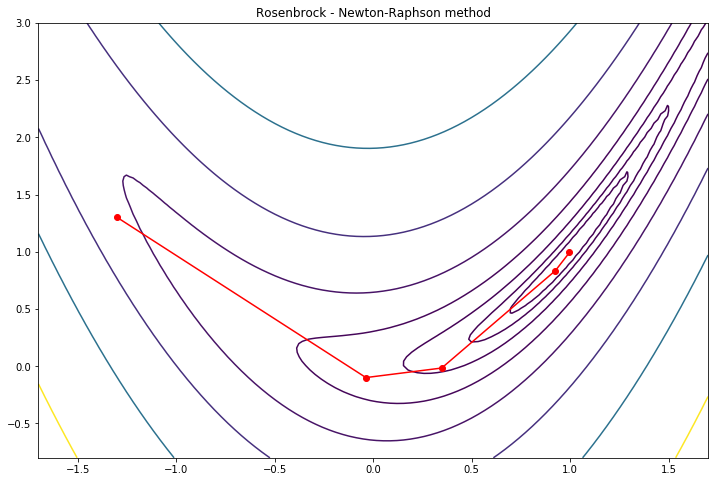

In [46]:
x,y = np.meshgrid(np.linspace(-1.7,1.7,100), np.linspace(-0.8,3,100))
R = [[Rosen(np.array([x[j,i],y[j,i]])) for i in range(size(x,0)) ] for j in range(size(x,1))]

fig = figure(figsize=(12,8))
contour(x, y, R, np.logspace(-1,2, 8), color="k")
title("Rosenbrock - Newton-Raphson method")

xmin, traj = newton_raphson(Rosen, dRosen, ddRosen, np.array([-1.3, 1.3]), 1e-1, 1e-8)
plot([traj[i][0] for i in range(len(traj))], [traj[i][1] for i in range(len(traj))], "r-o")

show()

- Often speeds up convergence
- When converges, will go to minimum, not saddle or maximum
- Can still sometimes fail (try starting from [-1.5,1.5] !), direction points uphill!
 - Fix: "trust region" methods ... 

## The problem with all Newton type methods...

Computing and inverting the Hessian is usually far too costly. 

- Computation often $O(n^2)$, inversion $O(n^3)$
- In real applications, $n$ can be thousands, or even millions
- Sometimes $H$ is sparse, which helps

## Congjuate Gradients as a search method

Consider minimizing the quadratic $f(x) = \frac12 x^T Q x - b^T x$

Even in the case of an ill-conditioned quadratic, if we could step along the eigendirections, things would be OK.


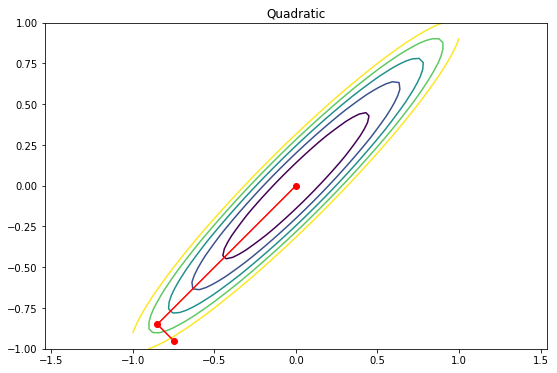

In [17]:
x, y = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))
Qxy = [[Q(np.array([x[j,i],y[j,i]])) for i in range(size(x,0)) ] for j in range(size(x,1))]
figure(figsize=(9,6))
contour(x, y, Qxy, linspace(0, 0.1, 6), color="k")
title("Quadratic")
axis('equal')

plot([-0.75, -0.85, 0], [-0.95, -0.85, 0], "r-o")

show()

But computing the eigenvectors is as expensive as inverting the Hessian.

Things would _also_ be OK, if the quadratic was along the axes (i.e. $Q$ is a diagonal matrix), and we stepped along the axis directions:

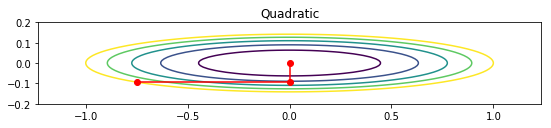

In [37]:
x, y = np.meshgrid(np.linspace(-1,1,50), np.linspace(-0.2,0.2,50))
def aQ(x):
    return x[0]**2+50*x[1]**2 
Qxy = [[aQ(np.array([x[j,i],y[j,i]])) for i in range(size(x,0)) ] for j in range(size(x,1))]
figure(figsize=(9,1.5))
contour(x, y, Qxy, linspace(0, 1, 6), color="k")
title("Quadratic")
axis('equal')

plot([-0.75, -0.0, 0], [-0.095, -0.095, 0], "r-o")

show()

Now consider a set of directions $\{d_k\}$ for which $d_i^T Q d_j = 0$ for $i\neq j$.

Collect the directions into a matrix, $$ S = \left[ d_1 d_2 \ldots d_N \right] $$

And transform the coordinates into $y = S^{-1} x$, and solving the problem in $y$:

$$ F(y) = f(x) = f(S y) = \frac12 y^T (S^T Q S) y - (S^T b)^T y$$

But the matrix $S^T Q S$ is diagonal! So the problem in $y$ space is a quadratic along the axes! The axes of $y$ space are the directions $\{d\}$.

How can we construct such a set of directions?

1. Let $d_0 = -\nabla f(x_0)$
1. Update location: $$x_{k+1} = x_k + \alpha_k d_k$$ (determine $\alpha_k$ with line search)
1. New direction: $$d_{k+1} = -\nabla f(x_{k+1}) + \left[\frac{|\nabla f(x_{k+1})|}{|\nabla f(x_k)|}\right]^2 d_k$$
1. Back to 2.

In [60]:
def conjugate_gradients(f, df, x0, ftol, xtol=1e-3, n_restart=None):
    traj = []
    
    # get initial direction
    x = x0[:]
    df_new = df(x)
    d = -1.0*df_new
    alpha_init = 1e-6
    i = 0
    #print i, f(x), np.linalg.norm(d), x[:], d[:]
    traj.append((x[0],x[1]))

    # loop until convergence
    while np.linalg.norm(df_new) > ftol:
        i += 1
        # do line search in current direction 
        alpha = linesearch_golden_section(f, x, d, alpha_init, xtol)
        # update estimate
        x += alpha*d
        # get beta
        df_old = df_new[:]
        df_new = df(x)
        beta = (np.linalg.norm(df_new)/np.linalg.norm(df_old))**2
        # get new direction
        if n_restart == None or i%n_restart != 0:
            d = beta*d
        d += -1.0*df_new
        
        #print i, f(x), np.linalg.norm(d), x[:], d[:]
        traj.append((x[0],x[1]))

    return x[:],traj


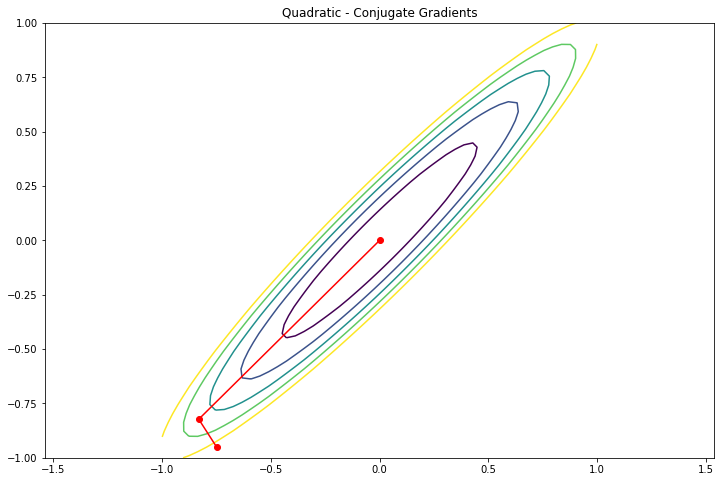

In [61]:
x, y = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))
Qxy = [[Q(np.array([x[j,i],y[j,i]])) for i in range(size(x,0)) ] for j in range(size(x,1))]
figure(figsize=(12,8))
contour(x, y, Qxy, linspace(0, 0.1, 6), color="k")
title("Quadratic - Conjugate Gradients")
axis('equal')

xmin, traj = conjugate_gradients(Q, dQ, np.array([-0.75, -0.95]), 1e-2, 1e-8)
plot([traj[i][0] for i in range(len(traj))], [traj[i][1] for i in range(len(traj))], "r-o")

show()

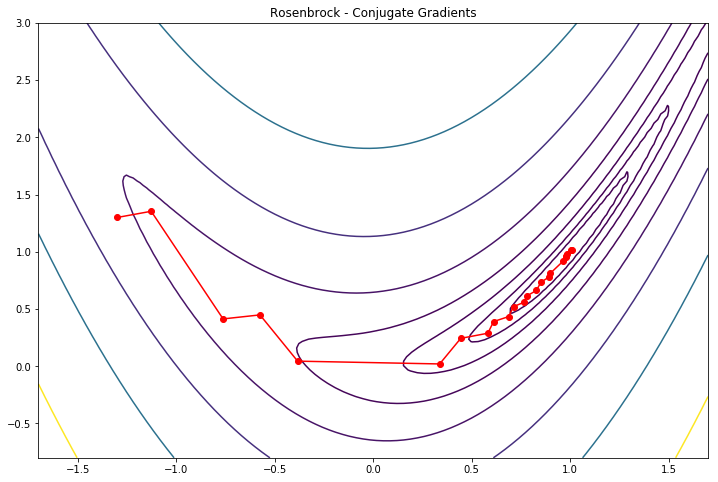

In [68]:
x,y = np.meshgrid(np.linspace(-1.7,1.7,100), np.linspace(-0.8,3,100))
R = [[Rosen(np.array([x[j,i],y[j,i]])) for i in range(size(x,0)) ] for j in range(size(x,1))]

fig = figure(figsize=(12,8))
contour(x, y, R, np.logspace(-1,2, 8), color="k")
title("Rosenbrock - Conjugate Gradients")
xmin, traj = conjugate_gradients(Rosen,dRosen, np.array([-1.3,1.3]), 1e-1, 1e-8,2)
plot([traj[i][0] for i in range(len(traj))], [traj[i][1] for i in range(len(traj))], "r-o")
show()

## Conjugate gradients remarks

- Will converge after $n$ iterations for an $n$ dimensional quadratic (with exact line search)
- For a nonlinear function, directions are _approximately_ conjugate
- Numerical errors lead to _loss of conjugacy_, algorithm can be periocally _reset_ by setting $d_k=-\nabla f(x_k)$
- Convergence is still _linear_, $$ \|x_{k+1}-x^*\| = \beta \|x_k - x^*\|$$
but $\beta$ can be very small, $\beta \approx 0$ ("superlinear convergence")
- Does _not_ require Hessian and its inversion
- Close links to solving linear systems $Qx = b$

## Summary of search methods

| Method | Advantages | Disadvantages |
---|---|---
| Steepest Descent | Only needs gradient | Linear convergence<br>slow for ill-conditioned problem |
| Newton's method | Quadratic Convergence | Needs Hessian<br>can diverge |
| Newton-Raphson | Quadratic Convergence<br> more reliable | Needs Hessian |
| Conjugate Gradients | Faster than Steepest Descent | Linear convergence |